<a href="https://colab.research.google.com/github/jofmorenore/Spatial_Clustering/blob/main/Hierarchical_clustering_of_spatially_correlated_fd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración del entorno R en colab

In [ ]:
# https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str
!pip install rpy2==3.5.1

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
getwd()

[1] "/content"


In [4]:
%%R
sessionInfo()

R version 4.3.0 (2023-04-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] compiler_4.3.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# “Canadian temperature” data (Ramsey & Silverman)

In [ ]:
%%R
library(dplyr)
library(ggplot2)

In [ ]:
%%R
if("geofd" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("geofd"))}
library(geofd)

In [ ]:
%%R
if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}
library(sf)

In [9]:
%%R
### Name: trace.variog
### Title: Empirical Variograms for function-value data
### Aliases: trace.variog geofd.trace.variog
### Keywords: spatial

### ** Examples


# First example: creating a binned variogram
# okfd first example

data(maritimes.avg) # Moncton averages
data(maritimes.coords) # The geographical coordinates in decimal degrees of 35 weather stations.
data(maritimes.data) # Temperature measurements recorded at 35 weather stations located in the Maritime Provinces over
                     # a region of Canada consisting of three provinces: Nova Scotia (NS), New Brunswick (NB), and
                     # Prince Edward Island (PEI)
head(maritimes.data[,1:6])

      [,1] [,2] [,3]   [,4]  [,5]  [,6]
[1,]  -7.9 -4.4 -3.8  -8.60 -3.36 -3.92
[2,]  -7.5 -4.2 -3.5  -8.32 -3.87 -4.77
[3,]  -9.3 -5.3 -4.6  -9.87 -4.23 -5.20
[4,]  -8.7 -5.4 -5.0  -9.55 -5.38 -5.35
[5,]  -9.1 -5.6 -4.1  -9.58 -5.75 -4.87
[6,] -10.9 -7.1 -6.1 -11.95 -6.84 -6.96


In [10]:
%%R
mundoshp <- sf::st_read("/content/drive/MyDrive/Curso/admin00.shp",quiet=TRUE)
Canada <- mundoshp %>% 
            filter(CNTRY_NAME %in% c("Canada"))
str(Canada, max.level = 1)

Classes ‘sf’ and 'data.frame':	13 obs. of  13 variables:
 $ FIPS_ADMIN: chr  "CA13" "CA12" "CA05" "CA09" ...
 $ GMI_ADMIN : chr  "CAN-NTR" "CAN-YTR" "CAN-NWF" "CAN-PEI" ...
 $ ADMIN_NAME: chr  "Northwest Territories" "Yukon Territory" "Newfoundland" "Prince Edward Island" ...
 $ FIPS_CNTRY: chr  "CA" "CA" "CA" "CA" ...
 $ GMI_CNTRY : chr  "CAN" "CAN" "CAN" "CAN" ...
 $ CNTRY_NAME: chr  "Canada" "Canada" "Canada" "Canada" ...
 $ POP_ADMIN : int  27928 28927 591593 135042 936538 7176389 27500 1136345 2649068 1029142 ...
 $ TYPE_ENG  : chr  "Territory" "Territory" "Province" "Province" ...
 $ TYPE_LOC  : chr  "Territory" "Territory" "Province" "Province" ...
 $ SQKM      : num  1338703 481287 396928 5959 55051 ...
 $ SQMI      : num  516873 185825 153254 2301 21255 ...
 $ COLOR_MAP : chr  "1" "8" "11" "7" ...
 $ geometry  :sfc_MULTIPOLYGON of length 13; first list element: List of 25
  ..- attr(*, "class")= chr [1:3] "XY" "MULTIPOLYGON" "sfg"
 - attr(*, "sf_column")= chr "geometry"
 - att

In [11]:
%%R
maritimes.point <- as.data.frame(maritimes.coords) %>%
                    st_as_sf(coords = c("V1", "V2"),
                             crs = 4326)
head(maritimes.point)

Simple feature collection with 6 features and 0 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -66.53 ymin: 44.43 xmax: -60.05 ymax: 47.01
Geodetic CRS:  WGS 84
              geometry
1 POINT (-66.53 45.87)
2 POINT (-63.52 44.88)
3 POINT (-60.05 46.17)
4 POINT (-65.47 47.01)
5 POINT (-64.48 45.07)
6  POINT (-65.2 44.43)


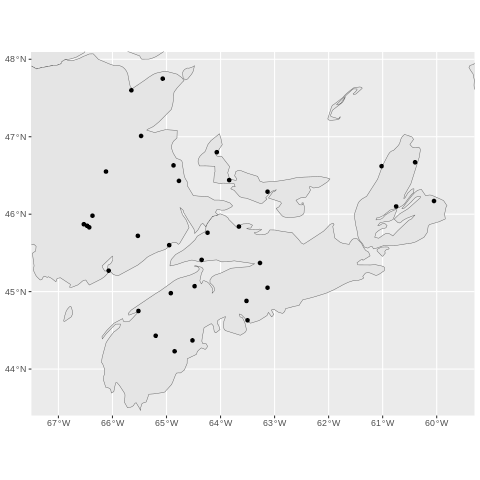

In [12]:
%%R
ggplot() + 
  geom_sf(data = Canada) +
  geom_sf(data = maritimes.point, col = 'black') +                    
  coord_sf(xlim=c(-67.5,-59.3),ylim=c(43.4,48.1), expand=FALSE)

NULL


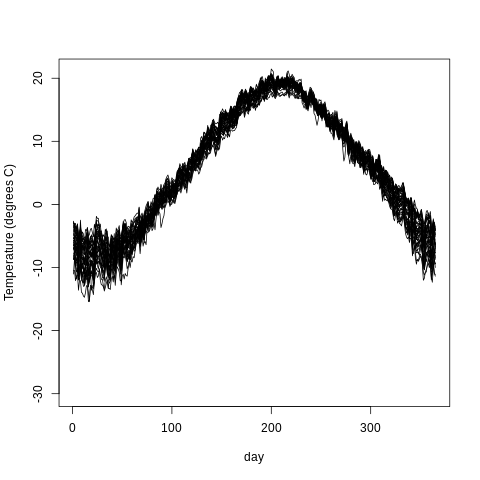

In [13]:
%%R
plot(maritimes.data[,1], type = 'l', ylab = 'Temperature (degrees C)', xlab = 'day', ylim =c(-30,21))
apply(maritimes.data[,-1], 2, function(x) lines(x))

# Smooth the observed data using [geodf](https://cran.r-project.org/web/packages/geofd/geofd.pdf)

A Fourier basis with 65 functions is used to smooth the discrete temperature values observed at each weather station

In [14]:
%%R
coord.cero <- matrix(c(-64.06, 45.79),nrow=1,ncol=2)
n<-dim(maritimes.data)[1]
argvals<-seq(1,n, by=1)

# This function allows to carry out prediction by Ordinary Kriging for function-value data by 
# considering a Fourier or B-splines basis for smoothing the observed data set
okfd.res<-okfd(new.coords=coord.cero, coords=maritimes.coords,
               data=maritimes.data, smooth.type='fourier',nbasis=65, argvals=argvals, fix.nugget=TRUE,
               kappa=0.7)

[1] "done"


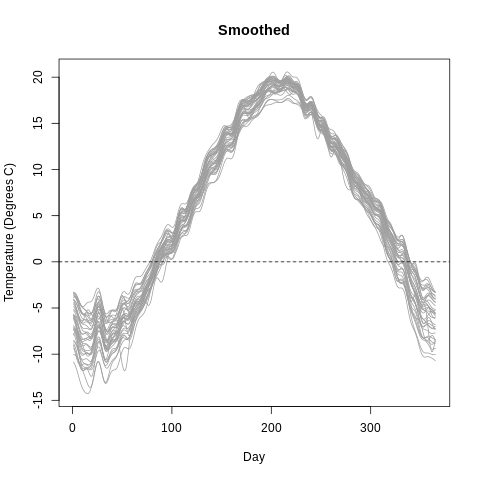

In [15]:
%%R
plot(okfd.res$datafd, lty=1, col=8,
     main="Smoothed", xlab="Day", ylab="Temperature (Degrees C)")

In [16]:
%%R
print(dim(okfd.res$datafd$coefs))
cat(rep('*',50), '\n')
print(str(okfd.res$datafd$basis))
cat(rep('*',50), '\n')
str(okfd.res$datafd$fdnames)

[1] 65 35
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
List of 10
 $ call       : language basisfd(type = type, rangeval = rangeval, nbasis = nbasis, params = params,      dropind = dropind, quadvals = qu| __truncated__
 $ type       : chr "fourier"
 $ rangeval   : num [1:2] 1 365
 $ nbasis     : num 65
 $ params     : int 365
 $ dropind    : num(0) 
 $ quadvals   : NULL
 $ values     : list()
 $ basisvalues: list()
 $ names      : chr [1:65] "const" "sin1" "cos1" "sin2" ...
 - attr(*, "class")= chr "basisfd"
NULL
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
List of 3
 $ time  : int [1:365] 1 2 3 4 5 6 7 8 9 10 ...
 $ reps  : chr [1:35] "rep1" "rep2" "rep3" "rep4" ...
 $ values: chr "value"


# Remove the spatial trend

In [17]:
%%R
print(dim(maritimes.coords))
length(okfd.res$datafd)

[1] 35  2
[1] 3


In [18]:
%%R
data(CanadianWeather, package = 'fda')
str(CanadianWeather, max.level = 1)

List of 8
 $ dailyAv      : num [1:365, 1:35, 1:3] -3.6 -3.1 -3.4 -4.4 -2.9 -4.5 -5.5 -3.1 -4 -5 ...
  ..- attr(*, "dimnames")=List of 3
 $ place        : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ province     : Named chr [1:35] "Newfoundland" "Nova Scotia" "Nova Scotia" "Nova Scotia" ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ coordinates  : num [1:35, 1:2] 47.3 44.4 46.1 43.5 42.5 ...
  ..- attr(*, "dimnames")=List of 2
 $ region       : Named chr [1:35] "Atlantic" "Atlantic" "Atlantic" "Atlantic" ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ monthlyTemp  : num [1:12, 1:35] -4.65 -5.33 -2.53 1.26 5.79 ...
  ..- attr(*, "dimnames")=List of 2
 $ monthlyPrecip: num [1:12, 1:35] 4.65 4.74 4.24 3.62 3.25 ...
  ..- attr(*, "dimnames")=List of 2
 $ geogindex    : Named num [1:35] 24 9 25 34 4 8 22 1 2 19 ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...


In [19]:
%%R
### functional response with vector explanatory variables
daybasis65 <- create.fourier.basis(rangeval=c(0, 365), nbasis=65,
                                   axes=list('axesIntervals'))
Temp.fd <- with(CanadianWeather, smooth.basisPar(day.5,
                                                 dailyAv[,,'Temperature.C'], daybasis65)$fd)

TempRgn.f <- fRegress(Temp.fd ~ region, CanadianWeather)
names(TempRgn.f)

 [1] "yfdobj"         "xfdlist"        "betalist"       "betaestlist"   
 [5] "yhatfdobj"      "Cmat"           "Dmat"           "Cmatinv"       
 [9] "wt"             "df"             "y2cMap"         "SigmaE"        
[13] "betastderrlist" "bvar"           "c2bMap"        


In [20]:
%%R
maritimes = list("data" = maritimes.data, "coords"= maritimes.coords)
maritimes$coords = as.data.frame(maritimes$coords) %>% `colnames<-`(c("Longitude", "Latitude"))

daybasis65 <- create.fourier.basis(rangeval=c(0, 365), nbasis=65,
                                   axes=list('axesIntervals'))
maritimes.fd <- smooth.basisPar(day.5, maritimes.data, daybasis65)$fd

Consider the functional linear model

$$ X_i(t) = \hat{\alpha}(t) + \hat{\alpha}_1(t) {Longitude}_i + \hat{\alpha}_2(t) {Latitude}_i + e_i(t) $$

In [21]:
%%R
maritimesRgn.f <- fRegress(maritimes.fd ~ Longitude + Latitude, maritimes$coords)
summary(maritimesRgn.f)

               Length Class  Mode   
yfdobj             3  fd     list   
xfdlist            3  -none- list   
betalist           3  -none- list   
betaestlist        3  -none- list   
yhatfdobj          3  fd     list   
Cmat           38025  -none- numeric
Dmat             195  -none- numeric
Cmatinv        38025  -none- numeric
wt                35  -none- numeric
df                 1  -none- logical
y2cMap             0  -none- NULL   
SigmaE             0  -none- NULL   
betastderrlist     0  -none- NULL   
bvar               0  -none- NULL   
c2bMap             0  -none- NULL   


[1] "done"


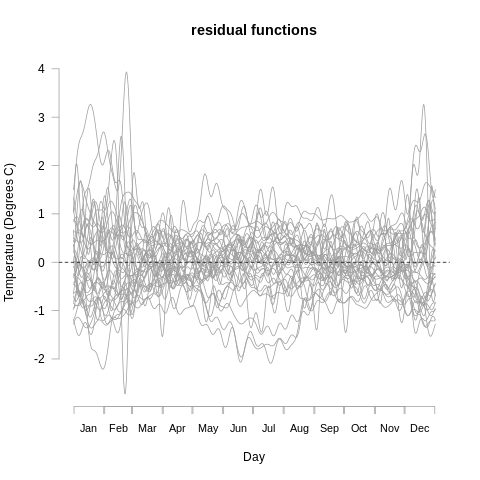

In [25]:
%%R
fdobj.res = maritimesRgn.f$yfdobj-maritimesRgn.f$yhatfdobj
plot(fdobj.res, lty=1, col=8,
     main="residual functions", xlab="Day", ylab="Temperature (Degrees C)")

[1] "done"


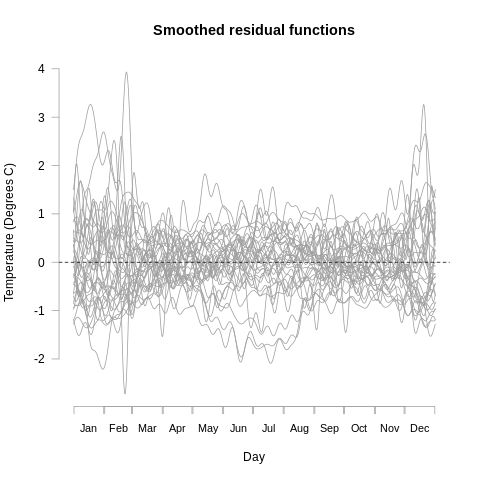

In [23]:
%%R
res.fd = smooth.fdPar(fdobj.res, Lfdobj=NULL, lambda=1e-4,estimate=TRUE, penmat=NULL)
plot(res.fd, lty=1, col=8,
     main="Smoothed residual functions", xlab="Day", ylab="Temperature (Degrees C)")

In [ ]:
%%R
# Calculating the empiricial trace bin variogram
new.emp.trace.vari <- trace.variog(coords=okfd.res$coords,
                                   L2norm=okfd.res$emp.trace.vari$L2norm, bin=TRUE)

fit.tracevariog(new.emp.trace.vari, models = "spherical", sigma2.0 = 7769, phi.0 = 2184,
                fix.nugget=FALSE, nugget=0,
                fix.kappa=TRUE, kappa=0.5,
                max.dist.variogram=NULL)